# Modelo massa-mola amortecido e forçado

Frederico Furst Bittencourt

2023/11/23 from 2022/09/17

Copied and modified from https://scipy-cookbook.readthedocs.io/items/CoupledSpringMassSystem.html (em 2002/jun/07).

## Intro

This file was created as part of the 

Tentative titles:

- The prediction of Strength, Damage Initiation and Damage Progression in the Open Hole, Filled Hole and Single-Shear Bearing tests for Composite Material Laminates and Chaos and Hyperchaos in the Triple Mass-Spring System Dynamic Response

- Chaos and Hyperchaos in the Triple Mass-Spring Dynamic Response and its application to the prediction of Strength, Damage Initiation and Damage Progression in the Open Hole, Filled Hole and Single-Shear Bearing tests for Composite Material Laminates

# Generalized n-Discrete Mass-Spring Model

#### Imports and Libraries

In [ ]:
# import nolds
import numpy as np
# Plot the solution that was generated
import matplotlib.pyplot as plt
# Use ODEINT to solve the differential equations defined by the vector field
from scipy.integrate import odeint, solve_ivp
# ks entropy
# import EntropyHub as EH

In [2]:
# import vapeplot
%matplotlib inline
# vapeplot.available()

In [3]:
# vapeplot.set_palette('macplus')

## Model Specification

In [4]:
forca_inicial = 0.0
forca_final = -249.97 # -1.0 # F0 = 249.97
tempo_inicial = 5.0
tempo_final = 25.0

## Definição do n

In [5]:
n = 1 # n > 2 seria a condicao de teste

In [6]:
249.97 / 0.01192

20970.637583892618

$ \frac{N}{mm}$

In [7]:
1.57*200*40*1.8288*2

45939.456

$\frac{g}{cm^3}*mm^3$

In [8]:
# Parameter values
# Masses:
# m1 = 2.0
m = 45.94/n # 2.0/n # m0 = 8.4 gramas

# Spring constants
# k1 = 5.0
k = 20970.7*n # 2.5*n 
# d = - 0.01192 mm
# F = 249.97 N
# k ~ 20970.7 N/mm

# Natural lengths
# L1 = 1.0
L = 200.0/n # 4.0/n
# L0 = 200.0 mm

# Friction coefficients
# b1 = 0.6
b = 10.6

# Initial conditions
# x1 and x2 are the initial displacements; y1 and y2 are the initial velocities
xizesys = [ (n+2)*L/2 if n%2==0 else 0.0 for n in range(2*n) ]
xizesys_desl = xizesys[:-2]

# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6
stoptime = 25.0
numpoints = 10000

# Create the time samples for the output of the ODE solver.
# I use a large number of points, only because I want to make
# a plot of the solution that looks nice.
t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]

## Entrada de Degrau de Força em $x_3$

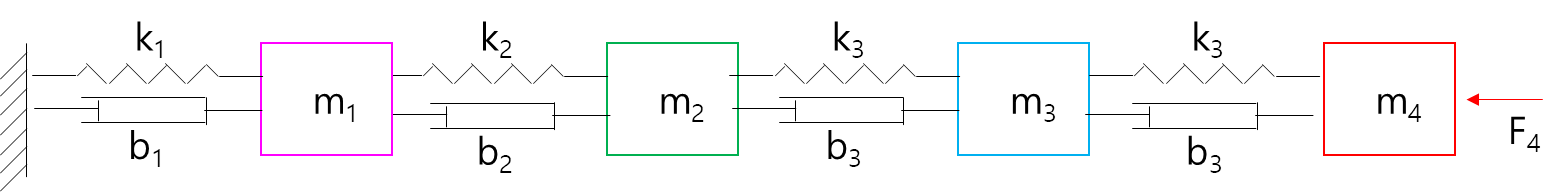

### Entradas

#### Degrau de Força de Entrada

In [9]:
# degrau de forca
def degrau_forca(t):
    if t <= 5.0:
        forca = forca_inicial
    else:
        forca = forca_final
    return forca

#### Campo Vetorial

In [10]:
len(range(2,2*n-2))

0

In [11]:
def degrau_forca_vectorfield_solve_ivp(t, w, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2,x3,y3]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,m3,k1,k2,k3,L1,L2,L3,b1,b2,b3]
    """
#    x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, x7, y7, x8, y8, x9, y9, \
#      x10, y10, x11, y11, x12, y12, x13, y13, x14, y14, x15, y15, x16, y16 = w
    # print(t)
    # print(w)
    # print(p)
    m, k, L, b = p

    # Create f = (x1',y1',x2',y2' ...):
    f = [ ]
    f.append( w[1] )
    if n == 1:
        f.append( (-b * w[1] - k * (w[0] - L) + degrau_forca(t))/ m )
    elif n >= 2:
        f.append( (-b * w[1] + b * (w[3] - w[1]) - k * (w[0] - L) + k * (w[2] - w[0] - L ) )/ m )
                # (-b * y1   + b * (y2   - y1)   - k * (x1   - L) + k * (x2     - x1    - L) ) / m,
        for i in range(2,2*n-2):
            if i % 2 == 0:
                f.append( w[i+1] )
            else:
                f.append( (-b * (w[i]-w[i-2]) + b * (w[i+2] - w[i]) - k * (w[i-1] - w[i-3] - L) + k * (w[i+1] - w[i-1] - L) ) / m )
    # item 2*n-2 = 2*16-2 = 32 - 2 = 30
        f.append( w[2*n-1] )
        f.append( (-b * (w[2*n-1] - w[2*n-3])  - k * (w[2*n-2] - w[2*n-4] - L) + degrau_forca(t)) / m )
    # y16,
    # (-b * (y16 - y15)  - k * (x16 - x15 - L) + degrau_forca(t)) / m,
    return f

### Saídas

#### Unpacking

In [12]:
# Pack up the parameters and initial conditions:
p = [m, k, L, b]
w0 = xizesys

# Call the ODE solver.
# wsol = odeint(degrau_forca_vectorfield, w0, t, args=(p,),
#               atol=abserr, rtol=relerr)
wsol = solve_ivp(degrau_forca_vectorfield_solve_ivp, (0.0, 25.0), w0, args=(p, ),
                 t_eval=t, atol=abserr, rtol=relerr)

at, ax, ay, = [],[[] for i in range(n)],[[] for i in range(n)],
# adendo
IE, KE = [[] for i in range(n)],[[] for i in range(n)],
ET = []
y = [list(i) for i in zip(*wsol.y)]
for t1, w1 in zip(wsol.t, y):
    # print( t1, w1[0], w1[1], w1[2], w1[3])
    at.append(t1)
    for i in range(n):
        ax[i].append(w1[2*i])
        ay[i].append(w1[2*i+1])
        if i==0:
            IE[i].append(k*(w1[2*i]-L)**2/2)
        else:
            IE[i].append(k*(w1[2*i]-w1[2*i-2]-L)**2/2)
        KE[i].append(m*w1[2*i+1]**2/2)
    ET.append(np.sum([k*(w1[2*i]-L)**2/2+m*w1[2*i+1]**2/2 if i == 0 else k*(w1[2*i]-w1[2*i-2]-L)**2/2+m*w1[2*i+1]**2/2 for i in range(n) ]))

#### Forças Aplicada e de Reação

Text(0.5, 1.0, 'Reaction and Applied Forces for 1-Discrete Spring-Mass System degrau forca')

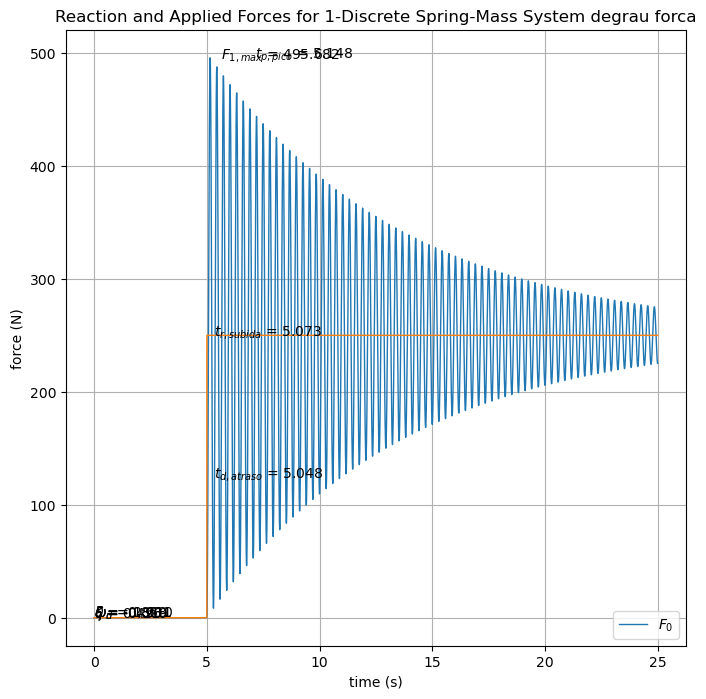

In [13]:
plt.figure(figsize=(8,8))
F = [[] for i in range(n)]
for i in range(n):
    if i == 0:
        F[i] = -k*np.array(ax[i]) + np.array([k*L for i in range(len(ax[i]))])
    else:
        F[i] = -k*np.array(ax[i]) +k*np.array(ax[i-1]) + np.array([k*L for i in range(len(ax[i]))])
    plt.plot(at, F[i], linewidth=1)
plt.plot(at, -np.array([ degrau_forca(t) for t in at ]), linewidth=1)

plt.text(
    at[np.where(F[0] == max(F[0]))[0][0]]+0.5,
    max(F[0]),
    '$F_{1,max}$ = '+str("{:.3f}".format(max(F[0])))
    )
array_diferencas = F[0] - (-forca_final)
indice_tr = np.abs(array_diferencas)[:np.where(F[0] == max(F[0]))[0][0]].argmin()
plt.text(
    at[indice_tr]+0.25,
    -forca_final-0.05,
    '$t_{r,subida}$ = '+str("{:.3f}".format(at[indice_tr]))
    )
array_diferencas = F[0] - (-forca_final/2)
indice_td = np.abs(array_diferencas)[:np.where(F[0] == max(F[0]))[0][0]].argmin()
plt.text(
    at[indice_td]+0.25,
    - forca_final/2,
    '$t_{d,atraso}$ = '+str("{:.3f}".format(at[indice_td]))
    )
indice_tp = np.where(F[0] == max(F[0]))[0][0]
plt.text(
    at[indice_tp]+2,
    F[0][indice_tp]-0.05,
    '$t_{p,pico}$ = '+str("{:.3f}".format(at[indice_tp]))
    )
tolerancia = 0.02
array_diferencas_abs = np.abs( F[0] - (-forca_final) )
indices_tol = np.where(array_diferencas_abs < tolerancia)[0]
comecos_de_pedacos = []
for i in range(len(indices_tol)-1):
  if indices_tol[i] != indices_tol[i+1]-1:
    comecos_de_pedacos.append(i)
# indice_ts = indices_tol[comecos_de_pedacos[-1]+1]
# plt.text(
#     at[indice_ts],
#     F[0][indice_ts]-0.05,
#     '$t_{s,assentamento}$ = '+str("{:.3f}".format(at[indice_ts]))
#     )
omega_d = np.pi/at[indice_tp]
plt.text(
    0.0, 1.0,
    '$\omega_d$ = '+str("{:.3f}".format(omega_d))
)
UP = max(F[0]) - (-forca_final)
xi = -np.log(UP)/np.sqrt(np.pi**2+np.log(UP)**2)
plt.text(
    0.0, 0.9,
    r'$\xi$ = '+str("{:.3f}".format(xi))
)
omega_n = omega_d/np.sqrt(1-xi*xi)
plt.text(
    0.0, 0.8,
    '$\omega_n$ = '+str("{:.3f}".format(omega_n))
)
zeta = np.sqrt(1-xi**2)
plt.text(
    0.0, 0.7,
    '$\zeta$ = '+str("{:.3f}".format(zeta))
)
theta = np.arctan(np.sqrt(1-xi**2)/xi)
plt.text(
    0.0, 0.6,
    r'$\theta$ = '+str("{:.3f}".format(theta))
)
plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('force (N)')
plt.legend([r'$F_{'+str(i)+r'}$' for i in range(n) ],loc='lower right')
plt.title('Reaction and Applied Forces for '+str(n)+'-Discrete Spring-Mass System degrau forca')

In [14]:
plt.figure(figsize=(8,8))
F = [[] for i in range(n)]
for i in range(n):
    if i == 0:
        F[i] = -k*np.array(ax[i]) + np.array([k*L for i in range(len(ax[i]))])
    else:
        F[i] = -k*np.array(ax[i]) +k*np.array(ax[i-1]) + np.array([k*L for i in range(len(ax[i]))])
    plt.plot(at, F[i], linewidth=1)
plt.plot(at, -np.array([ degrau_forca(t) for t in at ]), linewidth=1)
axis = plt.gca()
axis.set_xlim(4.9, 5.4)
# ax.set_ylim([ymin, ymax])
plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('force (N)')
plt.legend([r'$F_{'+str(i)+r'}$' for i in range(n) ],loc='lower right')
plt.title('Reaction and Applied Forces for '+str(n)+'-Discrete Spring-Mass System degrau forca')

Text(0.5, 1.0, 'Reaction and Applied Forces for 1-Discrete Spring-Mass System degrau forca')

Error in callback <function flush_figures at 0x000001F158E84AE0> (for post_execute):


KeyboardInterrupt: 

Text(0.5, 1.0, 'Reaction and Applied Forces for 7-Discrete Spring-Mass System degrau forca')

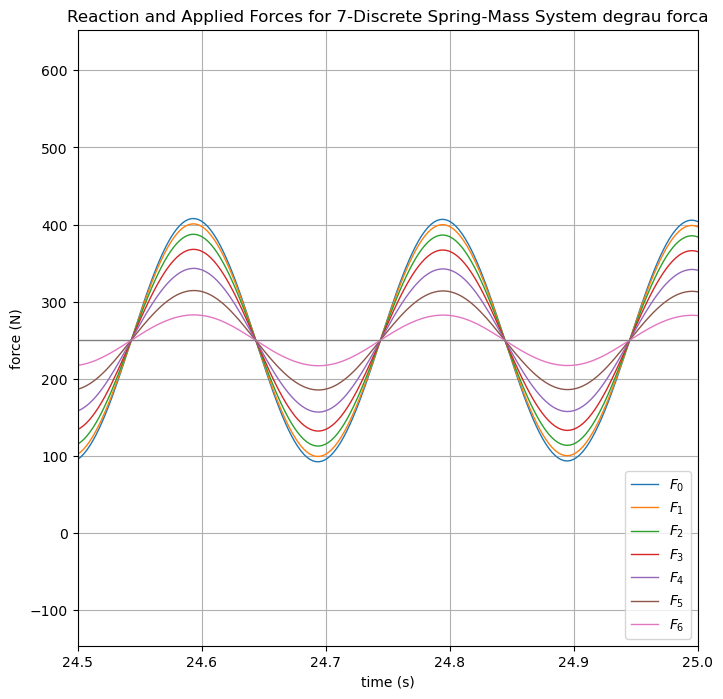

In [ ]:
plt.figure(figsize=(8,8))
F = [[] for i in range(n)]
for i in range(n):
    if i == 0:
        F[i] = -k*np.array(ax[i]) + np.array([k*L for i in range(len(ax[i]))])
    else:
        F[i] = -k*np.array(ax[i]) +k*np.array(ax[i-1]) + np.array([k*L for i in range(len(ax[i]))])
    plt.plot(at, F[i], linewidth=1)
plt.plot(at, -np.array([ degrau_forca(t) for t in at ]), linewidth=1)
axis = plt.gca()
axis.set_xlim([24.5, 25])
# ax.set_ylim([ymin, ymax])
plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('force (N)')
plt.legend([r'$F_{'+str(i)+r'}$' for i in range(n) ],loc='lower right')
plt.title('Reaction and Applied Forces for '+str(n)+'-Discrete Spring-Mass System degrau forca')

## Phase Space Plot

In [ ]:

r1, r2, r3 = 0.01, 0.02, 0.03
p=1

def ffplot2D_vel_desl(x3pre,y1pre):
    u = x3pre # *1e3
    v = y1pre # *np.sqrt(ms)*1e3
    plt.figure(figsize=(10,8))
    plt.grid(visible=True)
    plt.xlabel('Strain minus normalized ramp for ($\perthousand$)')
    plt.ylabel('Strain rate ($\perthousand.s^{-1}$)')
    plt.plot(u,v,)#'.')
    assert len(u) == len(v)
    n = len(u)
    distances = []
    delta_u = (max(u)-min(u))/2
    print('delta_u: '+str(delta_u))
    delta_v = (max(v)-min(v))/2
    print('delta_v: '+str(delta_v))
    for k in range(n-p):
        distances.append(np.sqrt(((u[k+p]-u[k])/delta_u)**2+((v[k+p]-v[k])/delta_v)**2))
    u1,u2,u3, v1,v2, v3 = [],[],[],[],[],[]
    for k in range(len(distances)):
        if distances[k] < r1:
            u1.append(u[k])
            v1.append(v[k])
        if distances[k] < r2:
            u2.append(u[k])
            v2.append(v[k])
        if distances[k] < r3:
            u3.append(u[k])
            v3.append(v[k])
    plt.title('1. Trajectories for strain rate x strain minus $v='+\
              '$ mm/s ramp\nat ')
    plt.plot(u3,v3,'.')
    plt.plot(u2,v2,'.')
    plt.plot(u1,v1,'.')
    plt.legend((r'$'+str(r3)+' \leq r$',r'$'+str(r2)+'\leq r<'+str(r3)+\
                '$',r'$'+str(r1)+' \leq r<'+str(r2)+'$',r'$0.0 \leq r<'+str(r1)+'$'))
    # plt.savefig('LE11_ER11_'+str(ig)+'_'+str(ms)+'.png')
    plt.show()

delta_u: 0.006256390151570201
delta_v: 0.29954434831041027


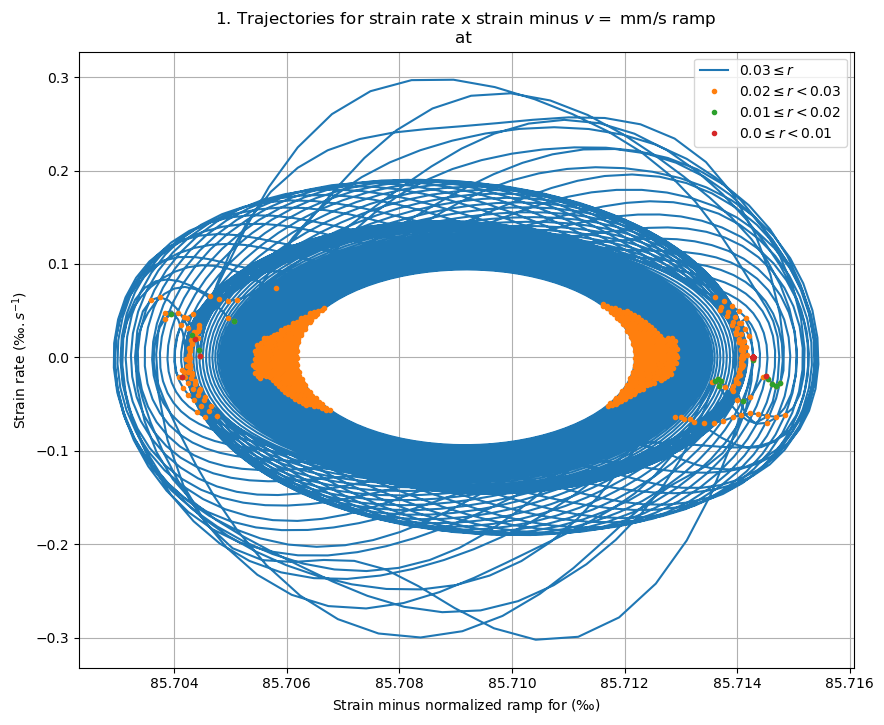

In [ ]:
ffplot2D_vel_desl(ax[0],ay[0])

In [ ]:
forcas = [ max(F[i]) for i in range(n) ]
forcas.index(max(forcas))

0

In [ ]:
forcas[forcas.index(max(forcas))]

616.3332033515908

#### Posições

Text(0.5, 1.0, 'Mass Displacements for 7-Discrete Spring-Mass System degrau forca')

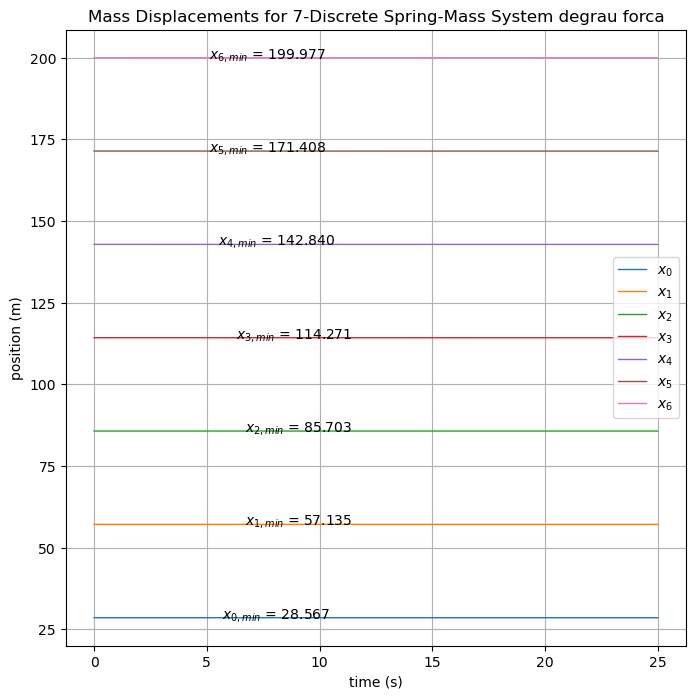

In [ ]:
plt.figure(figsize=(8,8))
for x in ax:
    plt.plot(at, x, linewidth=1)
    i = ax.index(x)
    plt.text(at[x.index(min(x))], min(x), '$x_{'+str(i)+',min}$ = '+str("{:.3f}".format(min(x))))

plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.legend([r'$x_{'+str(i)+r'}$' for i in range(n)])
plt.title('Mass Displacements for '+str(n)+'-Discrete Spring-Mass System degrau forca')

#### Velocidades

Text(0.5, 1.0, 'Mass Velocities for 7-Discrete Spring-Mass System degrau forca')

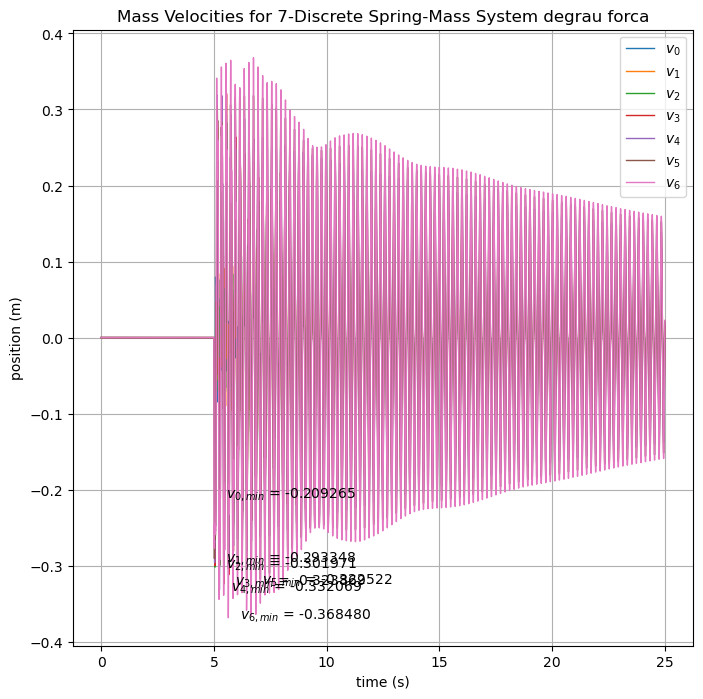

In [ ]:
plt.figure(figsize=(8,8))
for y in ay:
    plt.plot(at, y, linewidth=1)
    i = ay.index(y)
    plt.text(at[y.index(min(y))]+0.5, min(y), '$v_{'+str(i)+',min}$ = '+str("{:.6f}".format(min(y))))

plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.legend([r'$v_'+str(i)+r'$' for i in range(n)])
plt.title('Mass Velocities for '+str(n)+'-Discrete Spring-Mass System degrau forca')

#### Energias

Text(0.5, 1.0, 'Internal Energies for 7-Discrete Spring-Mass System degrau forca')

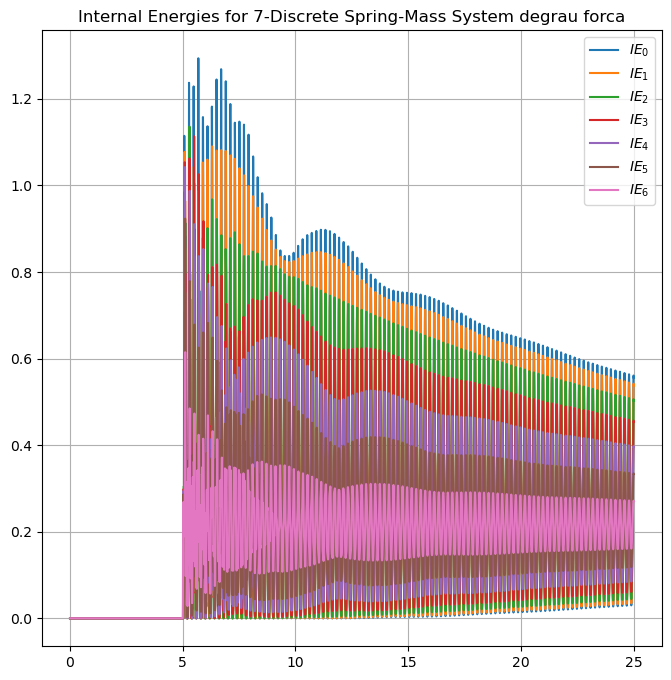

In [ ]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
for ie in IE:
    plt.plot(at,ie)
plt.legend([r'$IE_{'+str(i)+'}$' for i in range(n)])
plt.title('Internal Energies for '+str(n)+'-Discrete Spring-Mass System degrau forca')

In [ ]:
len(KE)

7

Text(0.5, 1.0, 'Kinetic Energies for 7-Discrete Spring-Mass System degrau forca')

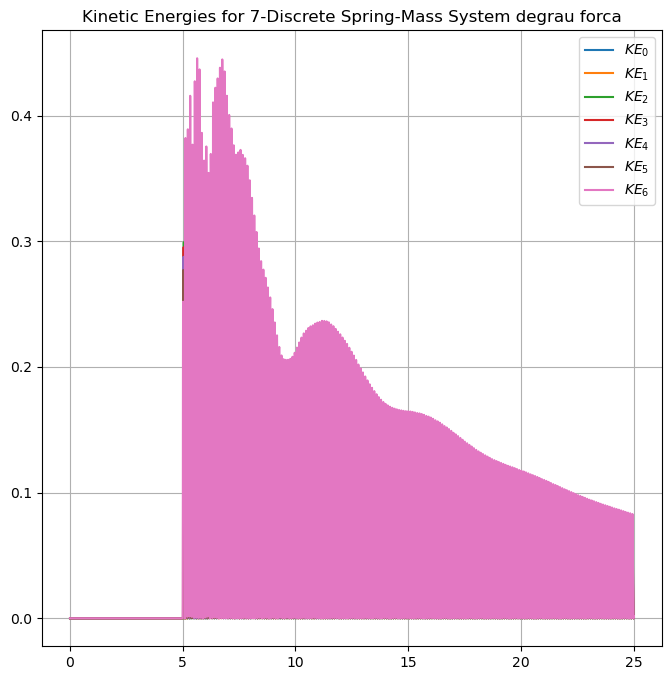

In [ ]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
for i in range(n):
    plt.plot(at,KE[i])
plt.legend([r'$KE_{'+str(i)+'}$' for i in range(n)])
plt.title('Kinetic Energies for '+str(n)+'-Discrete Spring-Mass System degrau forca')

Text(0.5, 1.0, 'Total Energy for 7-Discrete Spring-Mass System degrau forca')

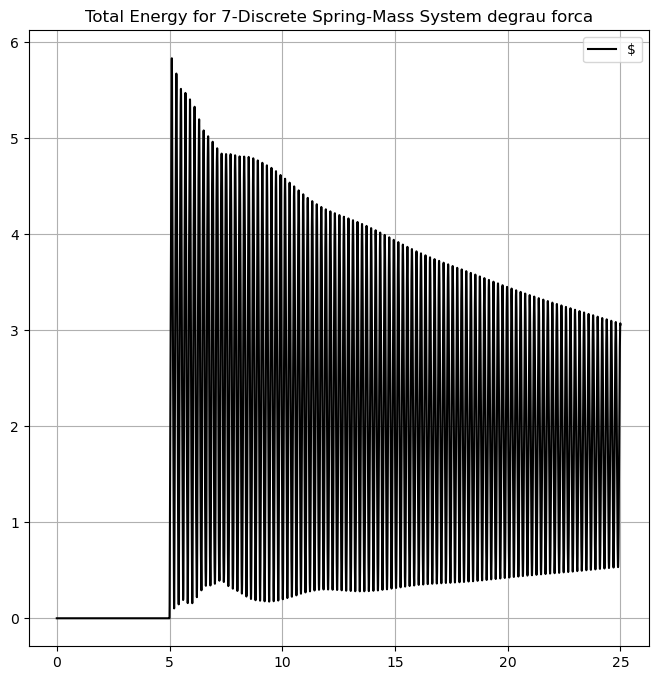

In [ ]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
plt.plot(at,ET,'black')
plt.legend(r'$E_T$')
plt.title('Total Energy for '+str(n)+'-Discrete Spring-Mass System degrau forca')

#### Extremos

In [ ]:
# print(np.array(
#     [ nolds.lyap_e(ax[i]) for i in range(n)]#,emb_dim=28,matrix_dim=10),
# ))
# print([
#   EH.K2En(ax[i], m=4) for i in range(n)
# ])

[[ 0.02692373  0.00476393 -0.02838013 -0.10260829]
 [ 0.02747085  0.00212712 -0.02331676 -0.0959254 ]
 [ 0.02161779  0.00209728 -0.02256974 -0.09847271]
 [ 0.02653252  0.00170588 -0.02523479 -0.10463975]
 [ 0.01569342  0.00079818 -0.01793112 -0.05845861]
 [ 0.02111286 -0.00080638 -0.02130548 -0.07945598]
 [ 0.0281122   0.00113281 -0.01870374 -0.07421801]]
[(array([0.2853377 , 0.25495695, 0.16788713, 0.1109156 ]), array([0.14551203, 0.10939017, 0.0847719 , 0.07167034, 0.06414598])), (array([0.27328492, 0.25089239, 0.17028107, 0.11142414]), array([0.14387441, 0.10947058, 0.08517972, 0.07184294, 0.06426777])), (array([0.27000062, 0.25390426, 0.17573578, 0.12108214]), array([0.14264702, 0.10889375, 0.08447607, 0.07086187, 0.06278087])), (array([0.26655295, 0.26196312, 0.16621611, 0.1210146 ]), array([0.1413599 , 0.10828386, 0.0833287 , 0.07056801, 0.06252474])), (array([0.26435139, 0.25013505, 0.16193583, 0.11357941]), array([0.13638226, 0.10470117, 0.08153034, 0.06934121, 0.06189627])), (


## Entrada de Rampa em Força em $x_3$

### Entradas

#### Rampa de Força de Entrada

In [ ]:
# rampa de forca
def rampa_forca(t):
    if t < tempo_inicial:
        forc = forca_inicial
    elif t >= tempo_inicial and t <= tempo_final:
        # forc = 5.0-1.0*t
        forc = forca_inicial+(forca_final-forca_inicial)/(10.0-5.0)*(t-5.0)
    else:
        forc = forca_final
    return forc

#### Campo Vetorial

In [ ]:
def rampa_forca_vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2,x3,y3]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,m3,k1,k2,k3,L1,L2,L3,b1,b2,b3]
    """
#    x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, x7, y7, x8, y8, x9, y9, \
#      x10, y10, x11, y11, x12, y12, x13, y13, x14, y14, x15, y15, x16, y16 = w
    m, k, L, b = p

    # Create f = (x1',y1',x2',y2' ...):
    f = [ ]
    f.append( w[1] )
    f.append( (-b * w[1] + b * (w[3] - w[1]) - k * (w[0] - L) + k * (w[2] - w[0] - L ) )/ m )
            # (-b * y1   + b * (y2   - y1)   - k * (x1   - L) + k * (x2     - x1    - L) ) / m,
    if n > 2:
        for i in range(2,2*n-2):
            if i % 2 == 0:
                f.append( w[i+1] )
            else:
                f.append( (-b * (w[i]-w[i-2]) + b * (w[i+2] - w[i]) - k * (w[i-1] - w[i-3] - L) + k * (w[i+1] - w[i-1] - L) ) / m )
    # item 2*n-2 = 2*16-2 = 32 - 2 = 30
    f.append( w[2*n-1] )
    f.append( (-b * (w[2*n-1] - w[2*n-3])  - k * (w[2*n-2] - w[2*n-4] - L) + rampa_forca(t)) / m )
    # y16,
    # (-b * (y16 - y15)  - k * (x16 - x15 - L) + degrau_forca(t)) / m,
    return f

### Saídas

#### Unpacking

In [ ]:
# Pack up the parameters and initial conditions:
p = [m, k, L, b]
# w0 = [x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, x7, y7, x8, y8, x9, y9, \
#       x10, y10, x11, y11, x12, y12, x13, y13, x14, y14, x15, y15, x16, y16]

w0 = xizesys

# Call the ODE solver.
wsol = odeint(rampa_forca_vectorfield, w0, t, args=(p,),
              atol=abserr, rtol=relerr)

at, ax, ay, = [],[[] for i in range(n)],[[] for i in range(n)],
# adendo
IE, KE = [[] for i in range(n)],[[] for i in range(n)],
ET = []
for t1, w1 in zip(t, wsol):
    # print( t1, w1[0], w1[1], w1[2], w1[3])
    at.append(t1)
    for i in range(n):
        ax[i].append(w1[2*i])
        ay[i].append(w1[2*i+1])
        if i==0:
            IE[i].append(k*(w1[2*i]-L)**2/2)
        else:
            IE[i].append(k*(w1[2*i]-w1[2*i-2]-L)**2/2)
        KE[i].append(m*w1[2*i+1]**2/2)
    ET.append(np.sum([k*(w1[2*i]-L)**2/2+m*w1[2*i+1]**2/2 if i == 0 else k*(w1[2*i]-w1[2*i-2]-L)**2/2+m*w1[2*i+1]**2/2 for i in range(n) ]))

#### Forças Aplicadas e de Reação

Text(0.5, 1.0, 'Reaction and Applied Forces for n-Discrete Spring-Mass System rampa forca')

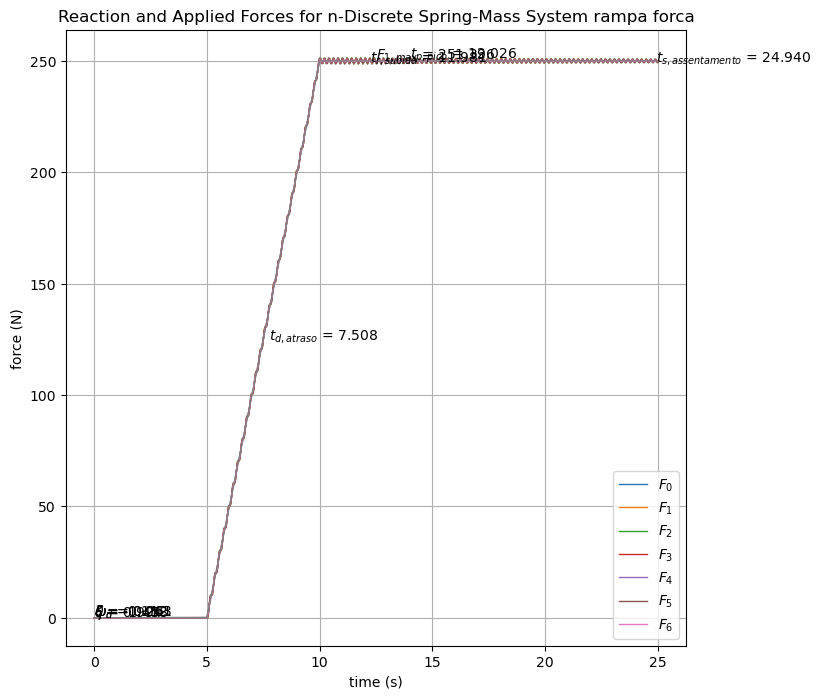

In [ ]:
plt.figure(figsize=(8,8))
F = [[] for i in range(n)]
for i in range(n):
    if i == 0:
        F[i] = -k*np.array(ax[i]) + np.array([k*L for i in range(len(ax[i]))])
    else:
        F[i] = -k*np.array(ax[i]) +k*np.array(ax[i-1]) + np.array([k*L for i in range(len(ax[i]))])
    plt.plot(at, F[i], linewidth=1)
plt.plot(at, -np.array([ rampa_forca(t) for t in at ]), linewidth=1)

plt.text(
    at[np.where(F[0] == max(F[0]))[0][0]]+0.5,
    max(F[0]),
    '$F_{1,max}$ = '+str("{:.3f}".format(max(F[0])))
    )
array_diferencas = F[0] - (-forca_final)
indice_tr = np.abs(array_diferencas)[:np.where(F[0] == max(F[0]))[0][0]].argmin()
plt.text(
    at[indice_tr]+0.25,
    -forca_final-0.05,
    '$t_{r,subida}$ = '+str("{:.3f}".format(at[indice_tr]))
    )
array_diferencas = F[0] - (-forca_final/2)
indice_td = np.abs(array_diferencas)[:np.where(F[0] == max(F[0]))[0][0]].argmin()
plt.text(
    at[indice_td]+0.25,
    - forca_final/2,
    '$t_{d,atraso}$ = '+str("{:.3f}".format(at[indice_td]))
    )
indice_tp = np.where(F[0] == max(F[0]))[0][0]
plt.text(
    at[indice_tp]+2,
    F[0][indice_tp]-0.05,
    '$t_{p,pico}$ = '+str("{:.3f}".format(at[indice_tp]))
    )
tolerancia = 0.02
array_diferencas_abs = np.abs( F[0] - (-forca_final) )
indices_tol = np.where(array_diferencas_abs < tolerancia)[0]
comecos_de_pedacos = []
for i in range(len(indices_tol)-1):
  if indices_tol[i] != indices_tol[i+1]-1:
    comecos_de_pedacos.append(i)
indice_ts = indices_tol[comecos_de_pedacos[-1]+1]
plt.text(
    at[indice_ts],
    F[0][indice_ts]-0.05,
    '$t_{s,assentamento}$ = '+str("{:.3f}".format(at[indice_ts]))
    )
omega_d = np.pi/at[indice_tp]
plt.text(
    0.0, 1.0,
    '$\omega_d$ = '+str("{:.3f}".format(omega_d))
)
UP = max(F[0]) - (-forca_final)
xi = -np.log(UP)/np.sqrt(np.pi**2+np.log(UP)**2)
plt.text(
    0.0, 0.9,
    r'$\xi$ = '+str("{:.3f}".format(xi))
)
omega_n = omega_d/np.sqrt(1-xi*xi)
plt.text(
    0.0, 0.8,
    '$\omega_n$ = '+str("{:.3f}".format(omega_n))
)
zeta = np.sqrt(1-xi**2)
plt.text(
    0.0, 0.7,
    '$\zeta$ = '+str("{:.3f}".format(zeta))
)
theta = np.arctan(np.sqrt(1-xi**2)/xi)
plt.text(
    0.0, 0.6,
    r'$\theta$ = '+str("{:.3f}".format(theta))
)
plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('force (N)')
plt.legend([r'$F_{'+str(i)+r'}$' for i in range(n) ],loc='lower right')
plt.title('Reaction and Applied Forces for n-Discrete Spring-Mass System rampa forca')

In [ ]:

r1, r2, r3 = 0.01, 0.02, 0.03
p=1

def ffplot2D_vel_desl(x3pre,y1pre):
    u = x3pre # *1e3
    v = y1pre # *np.sqrt(ms)*1e3
    plt.figure(figsize=(10,8))
    plt.grid(visible=True)
    plt.xlabel('Strain minus normalized ramp for ($\perthousand$)')
    plt.ylabel('Strain rate ($\perthousand.s^{-1}$)')
    plt.plot(u,v,)#'.')
    assert len(u) == len(v)
    n = len(u)
    distances = []
    delta_u = (max(u)-min(u))/2
    print('delta_u: '+str(delta_u))
    delta_v = (max(v)-min(v))/2
    print('delta_v: '+str(delta_v))
    for k in range(n-p):
        distances.append(np.sqrt(((u[k+p]-u[k])/delta_u)**2+((v[k+p]-v[k])/delta_v)**2))
    u1,u2,u3, v1,v2, v3 = [],[],[],[],[],[]
    for k in range(len(distances)):
        if distances[k] < r1:
            u1.append(u[k])
            v1.append(v[k])
        if distances[k] < r2:
            u2.append(u[k])
            v2.append(v[k])
        if distances[k] < r3:
            u3.append(u[k])
            v3.append(v[k])
    plt.title('1. Trajectories for strain rate x strain minus $v='+\
              '$ mm/s ramp\nat ')
    plt.plot(u3,v3,'.')
    plt.plot(u2,v2,'.')
    plt.plot(u1,v1,'.')
    plt.legend((r'$'+str(r3)+' \leq r$',r'$'+str(r2)+'\leq r<'+str(r3)+\
                '$',r'$'+str(r1)+' \leq r<'+str(r2)+'$',r'$0.0 \leq r<'+str(r1)+'$'))
    # plt.savefig('LE11_ER11_'+str(ig)+'_'+str(ms)+'.png')
    plt.show()

In [ ]:
ffplot2D_vel_desl(ax[0],ay[0])

In [ ]:
forcas = [ max(F[i]) for i in range(n) ]
forcas.index(max(forcas))

0

In [ ]:
forcas[forcas.index(max(forcas))]

251.3959513735026

#### Posições

Text(0.5, 1.0, 'Mass Displacements for 7-Discrete Spring-Mass System rampa forca')

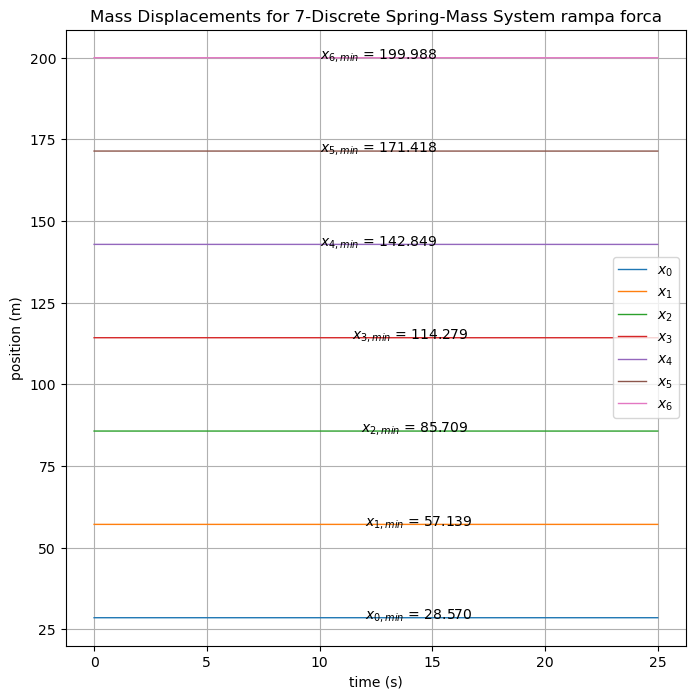

In [ ]:
plt.figure(figsize=(8,8))
for x in ax:
    plt.plot(at, x, linewidth=1)
    i = ax.index(x)
    plt.text(at[x.index(min(x))], min(x)-0.1, '$x_{'+str(i)+',min}$ = '+str("{:.3f}".format(min(x))))

plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.legend([r'$x_{'+str(i)+r'}$' for i in range(n)])
plt.title('Mass Displacements for '+str(n)+'-Discrete Spring-Mass System rampa forca')

#### Velocidades

Text(0.5, 1.0, 'Mass Velocities for 7-Discrete Spring-Mass System rampa forca')

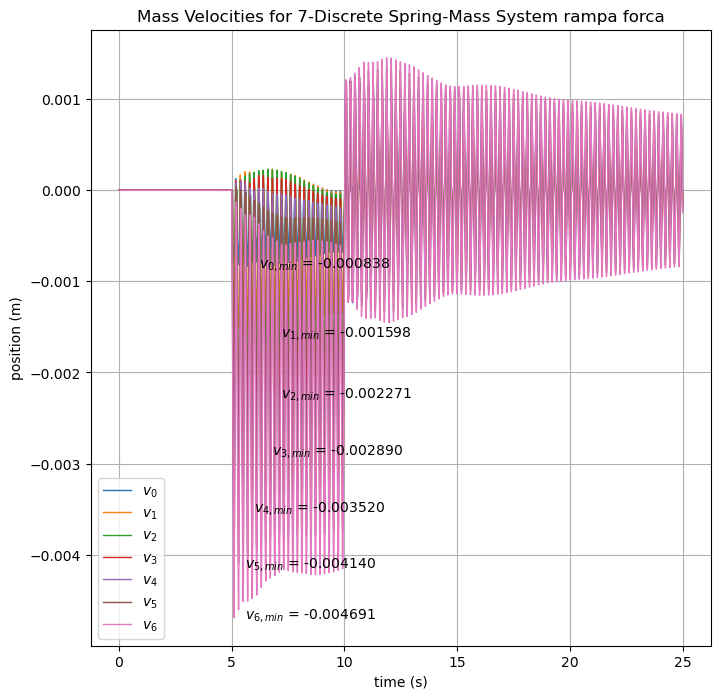

In [ ]:
plt.figure(figsize=(8,8))
for y in ay:
    plt.plot(at, y, linewidth=1)
    i = ay.index(y)
    plt.text(at[y.index(min(y))]+0.5, min(y), '$v_{'+str(i)+',min}$ = '+str("{:.6f}".format(min(y))))

plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.legend([r'$v_'+str(i)+r'$' for i in range(n)])
plt.title('Mass Velocities for '+str(n)+'-Discrete Spring-Mass System rampa forca')

#### Energias

Text(0.5, 1.0, 'Internal Energies for 7-Discrete Spring-Mass System rampa forca')

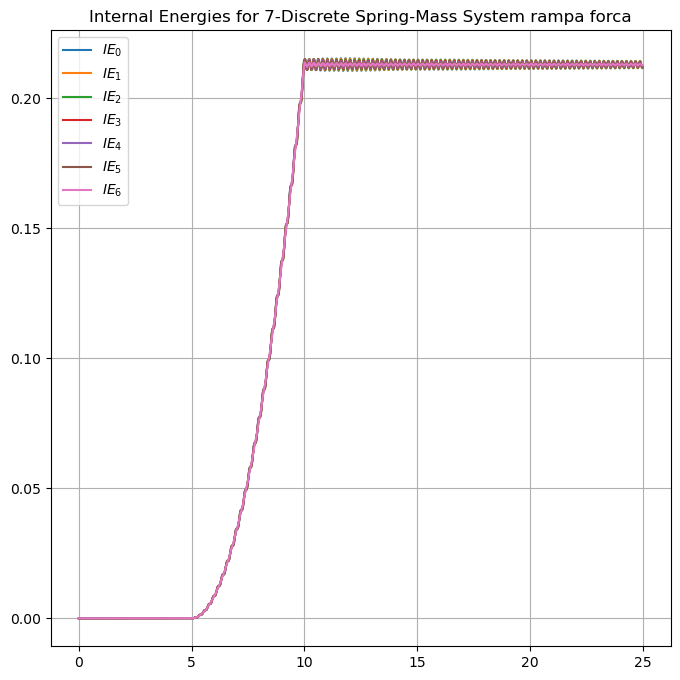

In [ ]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
for ie in IE:
    plt.plot(at,ie)
plt.legend([r'$IE_{'+str(i)+'}$' for i in range(n)])
plt.title('Internal Energies for '+str(n)+'-Discrete Spring-Mass System rampa forca')

Text(0.5, 1.0, 'Kinetic Energies for 7-Discrete Spring-Mass System rampa forca')

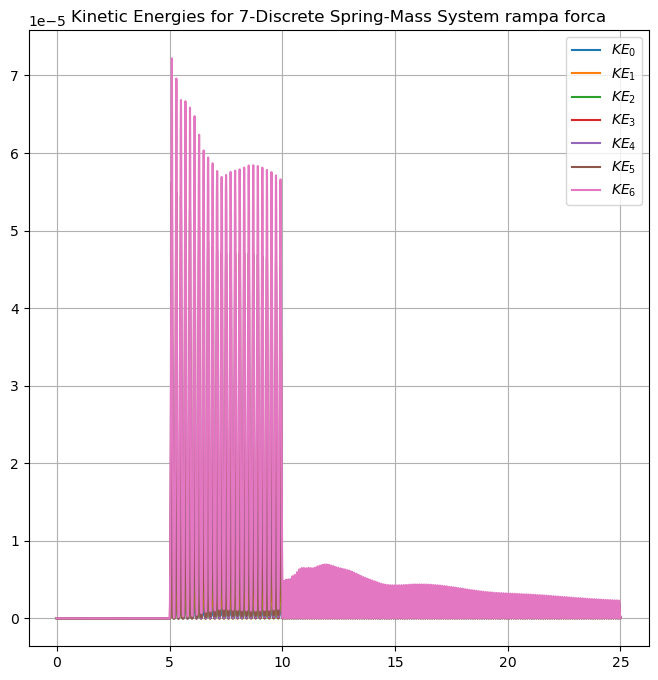

In [ ]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
for i in range(n):
    plt.plot(at,KE[i])
plt.legend([r'$KE_{'+str(i)+'}$' for i in range(n)])
plt.title('Kinetic Energies for '+str(n)+'-Discrete Spring-Mass System rampa forca')

Text(0.5, 1.0, 'Total Energy for 7-Discrete Spring-Mass System rampa forca')

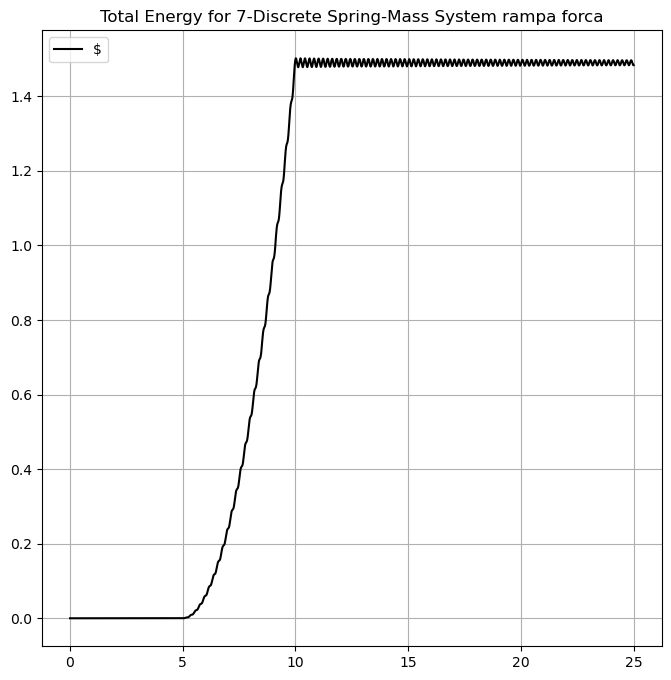

In [ ]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
plt.plot(at,ET,'black')
plt.legend((r'$E_T$'))
plt.title('Total Energy for '+str(n)+'-Discrete Spring-Mass System rampa forca')

#### Extremos

In [ ]:
# print(np.array(
#     [ nolds.lyap_e(ax[i]) for i in range(n)]#,emb_dim=28,matrix_dim=10),
# ))
# print([
#   EH.K2En(ax[i], m=4) for i in range(n)
# ])

[[ 0.04866424  0.01088843 -0.04204385 -0.14122975]
 [ 0.04598248  0.0075446  -0.04180565 -0.1386724 ]
 [ 0.04951429  0.00474155 -0.04004756 -0.13290563]
 [ 0.03103077  0.00248694 -0.04069019 -0.14784096]
 [ 0.01838591  0.0029417  -0.02118535 -0.05748063]
 [ 0.05697748 -0.0021946  -0.04217128 -0.14066344]
 [ 0.03297457 -0.00310288 -0.03022964 -0.10539594]]
[(array([0.03080911, 0.00576528, 0.00449717, 0.01146184]), array([0.4017841 , 0.38959423, 0.38735457, 0.38561649, 0.38122184])), (array([0.03062753, 0.00601299, 0.00436903, 0.01135868]), array([0.40074991, 0.38866199, 0.38633198, 0.38464777, 0.3803034 ])), (array([0.0291582 , 0.00504867, 0.00364967, 0.00978484]), array([0.40752739, 0.3958162 , 0.39382289, 0.39238818, 0.38856745])), (array([0.03034324, 0.00609135, 0.00480576, 0.01010324]), array([0.40037016, 0.38840409, 0.38604538, 0.38419459, 0.38033252])), (array([0.02970797, 0.00614773, 0.00467914, 0.00922944]), array([0.39904186, 0.3873615 , 0.38498741, 0.38319021, 0.37966985])), (

## Entrada de Rampa em Deslocamento em $x_3$

### Entradas

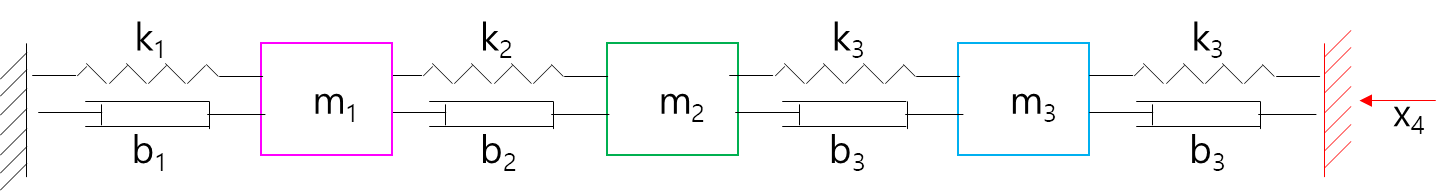

#### Rampa em Degrau de Entrada

In [ ]:
def rampa_disp(t):
    return rampa_forca(t)*(n/k)+(n*L)

Criando uma derivada da função rampa definida de forma simbólica.

In [ ]:
from sympy import Piecewise
from sympy import symbols

In [ ]:
tempo = symbols('t')
rampa_desl = Piecewise(
    (forca_inicial*(n/k)+(n*L), (tempo > 0.0) & (tempo < tempo_inicial)),
    (n/k*(forca_inicial+(forca_final-forca_inicial)/(tempo_final-tempo_inicial)*(tempo-tempo_inicial))+n*L, \
      (tempo >= tempo_inicial) & (tempo < tempo_final)),
    (forca_final*(n/k)+(n*L), (tempo >= tempo_final))
)
rampa_desl_derivada = rampa_desl.diff(tempo)
rampa_desl.diff(tempo)

Piecewise((0, (t < 5.0) & (t > 0)), (-0.00238399290438564, (t >= 5.0) & (t < 10.0)), (0, t >= 10.0))

In [ ]:
def deriv_desl(t):
     if t < tempo_inicial:
         dd = 0.0
     elif t >= tempo_inicial and t <= tempo_final:
         # forc = 5.0-1.0*t
         dd = n/k*(forca_inicial+(forca_final-forca_inicial)/(tempo_final-tempo_inicial))
     else:
         dd = 0.0
     return dd

In [ ]:
rampa_desl

Piecewise((200.0, (t < 5.0) & (t > 0)), (200.011919964522 - 0.00238399290438564*t, (t >= 5.0) & (t < 10.0)), (199.988080035478, t >= 10.0))

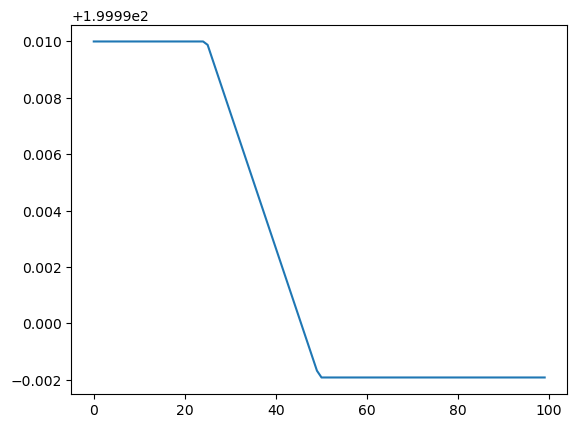

In [ ]:
plt.plot([ rampa_disp(t) for t in np.linspace(0.0,20.0,100)])

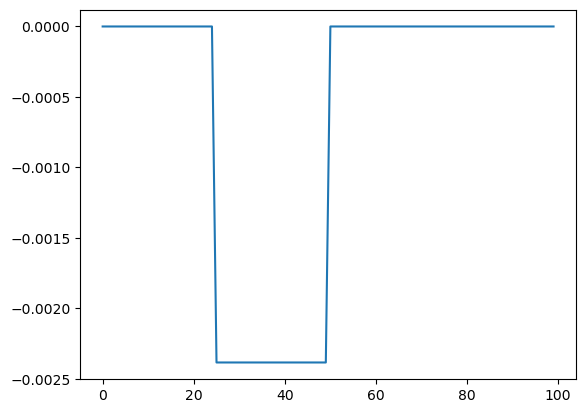

In [ ]:
plt.plot([ deriv_desl(t) for t in np.linspace(0.0,20.0,100)])

#### Campo Vetorial

In [ ]:
def rampa_desl_vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2,x3,y3]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,m3,k1,k2,k3,L1,L2,L3,b1,b2,b3]
    """
#    x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, x7, y7, x8, y8, x9, y9, \
#      x10, y10, x11, y11, x12, y12, x13, y13, x14, y14, x15, y15, x16, y16 = w
    m, k, L, b = p

    # Create f = (x1',y1',x2',y2' ...):
    f = [ ]
    f.append( w[1] )
    if n > 2:
        f.append( (-b * w[1] + b * (w[3] - w[1]) - k * (w[0] - L) + k * (w[2] - w[0] - L ) )/ m )
    elif n==2:
        f.append( (-b * w[1] + b * (deriv_desl(t) - w[1]) - k * (w[0] - L) + k * (rampa_disp(t) - w[0] - L ) )/ m )
    if n > 2:
        for i in range(2,2*n-4):
            if i % 2 == 0:
                f.append( w[i+1] )
            else:
                f.append( (-b * (w[i]-w[i-2]) + b * (w[i+2] - w[i]) - k * (w[i-1] - w[i-3] - L) + k * (w[i+1] - w[i-1] - L) ) / m )
    # item 2*n-2 = 2*16-2 = 32 - 2 = 30
        f.append( w[2*n-3] )
        f.append( (-b * (w[2*n-3] - w[2*n-5]) + b * (deriv_desl(t) - w[2*n-3]) - k * (w[2*n-4] - w[2*n-6] - L) + k * (rampa_disp(t) - w[2*n-4] -L) ) / m )
    # y15,
    # (-b * (y15 - y14) + b * (deriv_desl(t) - y15) - k * (x15 - x14 - L) + k * (rampa_disp(t) - x15 - L) ) / m,
    return f

### Saídas

#### Unpacking

In [ ]:
# Pack up the parameters and initial conditions:
p = [m, k, L, b]
w0 = xizesys_desl # [x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, x7, y7, x8, y8, x9, y9, \
     #  x10, y10, x11, y11, x12, y12, x13, y13, x14, y14, x15, y15,] #  x16, y16]

# Call the ODE solver.
wsol = odeint(rampa_desl_vectorfield, w0, t, args=(p,),
              atol=abserr, rtol=relerr)

at, ax, ay, = [],[[] for i in range(n)],[[] for i in range(n)],
# adendo
IE, KE = [[] for i in range(n)],[[] for i in range(n)],
ET = []
for t1, w1 in zip(t, wsol):
    # print( t1, w1[0], w1[1], w1[2], w1[3])
    at.append(t1)
    ETt = 0.0
    for i in range(n):
        if i==0:
            IE[i].append(k*(w1[2*i]-L)**2/2)
            KE[i].append(m*w1[2*i+1]**2/2)
            ax[i].append(w1[2*i])
            ay[i].append(w1[2*i+1])
            ETt += k*(w1[2*i]-L)**2/2+m*w1[2*i+1]**2/2
        elif i==n-1:
            IE[i].append(k*(rampa_disp(t1)-w1[2*i-2]-L)**2/2)
            KE[i].append(m*deriv_desl(t1)**2/2)
            ax[i].append(rampa_disp(t1))
            ay[i].append(deriv_desl(t1))
            ETt += k*(rampa_disp(t1)-w1[2*i-2]-L)**2/2+m*deriv_desl(t1)**2/2
        else:
            IE[i].append(k*(w1[2*i]-w1[2*i-2]-L)**2/2)
            KE[i].append(m*w1[2*i+1]**2/2)
            ax[i].append(w1[2*i])
            ay[i].append(w1[2*i+1])
            ETt += k*(w1[2*i]-w1[2*i-2]-L)**2/2+m*w1[2*i+1]**2/2
    ET.append(ETt)

#### Forças de Reação

Text(0.5, 1.0, 'Reaction and Applied Forces for 7-Discrete Spring-Mass System rampa desl')

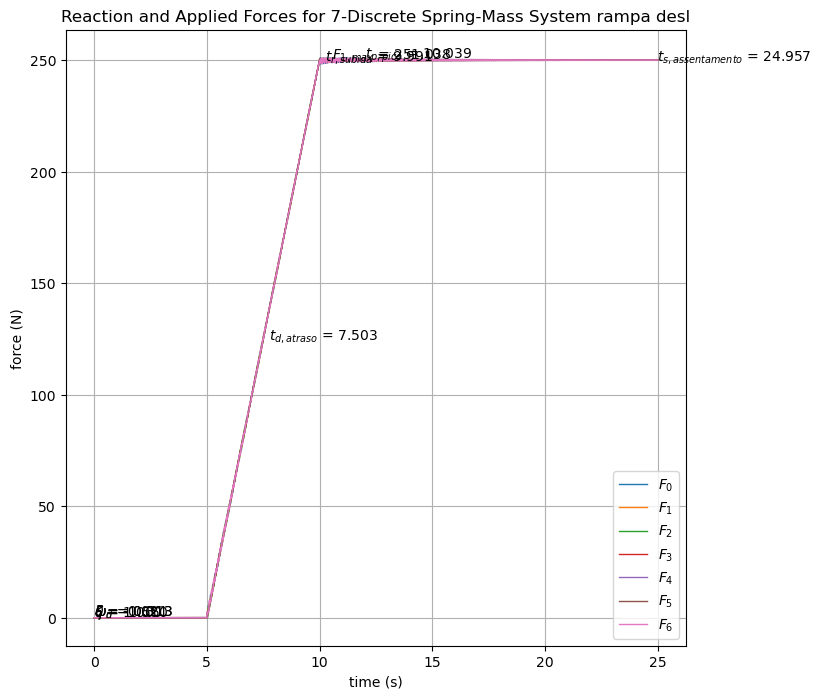

In [ ]:
plt.figure(figsize=(8,8))
F = [[] for i in range(n)]
for i in range(n):
    if i == 0:
        F[i] = -k*np.array(ax[i]) + np.array([k*L for i in range(len(ax[i]))])
    else:
        F[i] = -k*np.array(ax[i]) +k*np.array(ax[i-1]) + np.array([k*L for i in range(len(ax[i]))])
    plt.plot(at, F[i], linewidth=1)

plt.text(
    at[np.where(F[0] == max(F[0]))[0][0]]+0.5,
    max(F[0]),
    '$F_{1,max}$ = '+str("{:.3f}".format(max(F[0])))
    )
array_diferencas = F[0] - (-forca_final)
indice_tr = np.abs(array_diferencas)[:np.where(F[0] == max(F[0]))[0][0]].argmin()
plt.text(
    at[indice_tr]+0.25,
    -forca_final-0.05,
    '$t_{r,subida}$ = '+str("{:.3f}".format(at[indice_tr]))
    )
array_diferencas = F[0] - (-forca_final/2)
indice_td = np.abs(array_diferencas)[:np.where(F[0] == max(F[0]))[0][0]].argmin()
plt.text(
    at[indice_td]+0.25,
    - forca_final/2,
    '$t_{d,atraso}$ = '+str("{:.3f}".format(at[indice_td]))
    )
indice_tp = np.where(F[0] == max(F[0]))[0][0]
plt.text(
    at[indice_tp]+2,
    F[0][indice_tp]-0.05,
    '$t_{p,pico}$ = '+str("{:.3f}".format(at[indice_tp]))
    )
tolerancia = 0.02
array_diferencas_abs = np.abs( F[0] - (-forca_final) )
indices_tol = np.where(array_diferencas_abs < tolerancia)[0]
comecos_de_pedacos = []
for i in range(len(indices_tol)-1):
  if indices_tol[i] != indices_tol[i+1]-1:
    comecos_de_pedacos.append(i)
indice_ts = indices_tol[comecos_de_pedacos[-1]+1]
plt.text(
    at[indice_ts],
    F[0][indice_ts]-0.05,
    '$t_{s,assentamento}$ = '+str("{:.3f}".format(at[indice_ts]))
    )
omega_d = np.pi/at[indice_tp]
plt.text(
    0.0, 1.0,
    '$\omega_d$ = '+str("{:.3f}".format(omega_d))
)
UP = max(F[0]) - (-forca_final)
xi = -np.log(UP)/np.sqrt(np.pi**2+np.log(UP)**2)
plt.text(
    0.0, 0.9,
    r'$\xi$ = '+str("{:.3f}".format(xi))
)
omega_n = omega_d/np.sqrt(1-xi*xi)
plt.text(
    0.0, 0.8,
    '$\omega_n$ = '+str("{:.3f}".format(omega_n))
)
zeta = np.sqrt(1-xi**2)
plt.text(
    0.0, 0.7,
    '$\zeta$ = '+str("{:.3f}".format(zeta))
)
theta = np.arctan(np.sqrt(1-xi**2)/xi)
plt.text(
    0.0, 0.6,
    r'$\theta$ = '+str("{:.3f}".format(theta))
)
plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('force (N)')
plt.legend([r'$F_{'+str(i)+r'}$' for i in range(n) ],loc='lower right')
plt.title('Reaction and Applied Forces for '+str(n)+'-Discrete Spring-Mass System rampa desl')

In [ ]:

r1, r2, r3 = 0.01, 0.02, 0.03
p=1

def ffplot2D_vel_desl(x3pre,y1pre):
    u = x3pre # *1e3
    v = y1pre # *np.sqrt(ms)*1e3
    plt.figure(figsize=(10,8))
    plt.grid(visible=True)
    plt.xlabel('Strain minus normalized ramp for ($\perthousand$)')
    plt.ylabel('Strain rate ($\perthousand.s^{-1}$)')
    plt.plot(u,v,)#'.')
    assert len(u) == len(v)
    n = len(u)
    distances = []
    delta_u = (max(u)-min(u))/2
    print('delta_u: '+str(delta_u))
    delta_v = (max(v)-min(v))/2
    print('delta_v: '+str(delta_v))
    for k in range(n-p):
        distances.append(np.sqrt(((u[k+p]-u[k])/delta_u)**2+((v[k+p]-v[k])/delta_v)**2))
    u1,u2,u3, v1,v2, v3 = [],[],[],[],[],[]
    for k in range(len(distances)):
        if distances[k] < r1:
            u1.append(u[k])
            v1.append(v[k])
        if distances[k] < r2:
            u2.append(u[k])
            v2.append(v[k])
        if distances[k] < r3:
            u3.append(u[k])
            v3.append(v[k])
    plt.title('1. Trajectories for strain rate x strain minus $v='+\
              '$ mm/s ramp\nat ')
    plt.plot(u3,v3,'.')
    plt.plot(u2,v2,'.')
    plt.plot(u1,v1,'.')
    plt.legend((r'$'+str(r3)+' \leq r$',r'$'+str(r2)+'\leq r<'+str(r3)+\
                '$',r'$'+str(r1)+' \leq r<'+str(r2)+'$',r'$0.0 \leq r<'+str(r1)+'$'))
    # plt.savefig('LE11_ER11_'+str(ig)+'_'+str(ms)+'.png')
    plt.show()

In [ ]:
ffplot2D_vel_desl(ax[0],ay[0])

In [ ]:
forcas = [ max(F[i]) for i in range(n) ]
forcas.index(max(forcas))

0

#### Posições

Text(0.5, 1.0, 'Mass Displacements for 7-Discrete Spring-Mass System rampa desl')

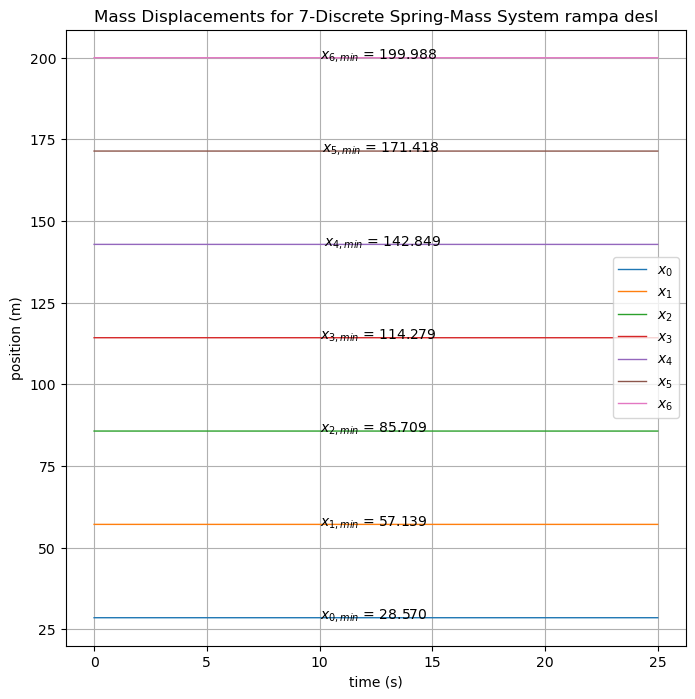

In [ ]:
plt.figure(figsize=(8,8))
for x in ax:
    plt.plot(at, x, linewidth=1)
    i = ax.index(x)
    plt.text(at[x.index(min(x))], min(x)-0.1, '$x_{'+str(i)+',min}$ = '+str("{:.3f}".format(min(x))))

plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.legend([r'$x_{'+str(i)+r'}$' for i in range(n)])
plt.title('Mass Displacements for '+str(n)+'-Discrete Spring-Mass System rampa desl')

#### Velocidades

Text(0.5, 1.0, 'Mass Velocities for 7-Discrete Spring-Mass System rampa desl')

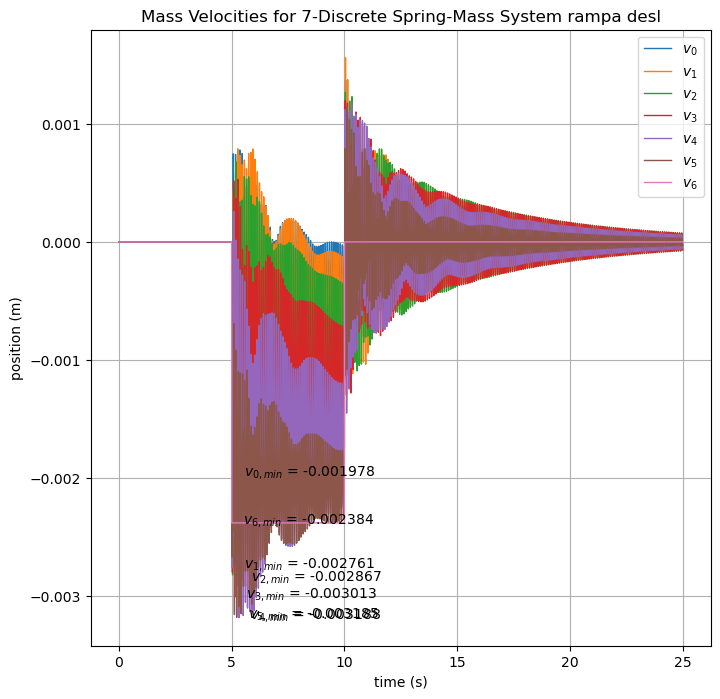

In [ ]:
plt.figure(figsize=(8,8))
for y in ay:
    plt.plot(at, y, linewidth=1)
    i = ay.index(y)
    plt.text(at[y.index(min(y))]+0.5, min(y), '$v_{'+str(i)+',min}$ = '+str("{:.6f}".format(min(y))))

plt.grid(visible=True)
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.legend([r'$v_'+str(i)+r'$' for i in range(n)])
plt.title('Mass Velocities for '+str(n)+'-Discrete Spring-Mass System rampa desl')

#### Energias

Text(0.5, 1.0, 'Internal Energies for7-Discrete Spring-Mass System rampa desl')

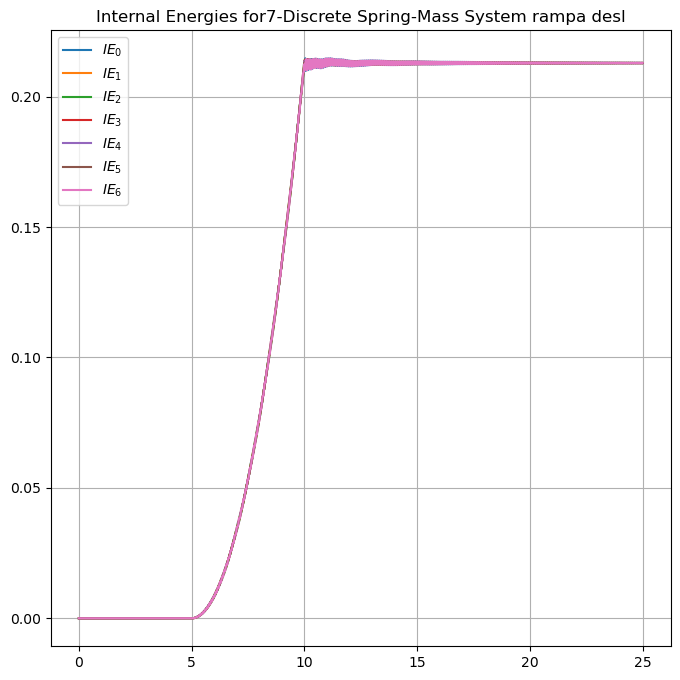

In [ ]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
for ie in IE:
    plt.plot(at,ie)
plt.legend([r'$IE_{'+str(i)+'}$' for i in range(n)])
plt.title('Internal Energies for'+str(n)+'-Discrete Spring-Mass System rampa desl')

Text(0.5, 1.0, 'Kinetic Energies for 7-Discrete Spring-Mass System rampa desl')

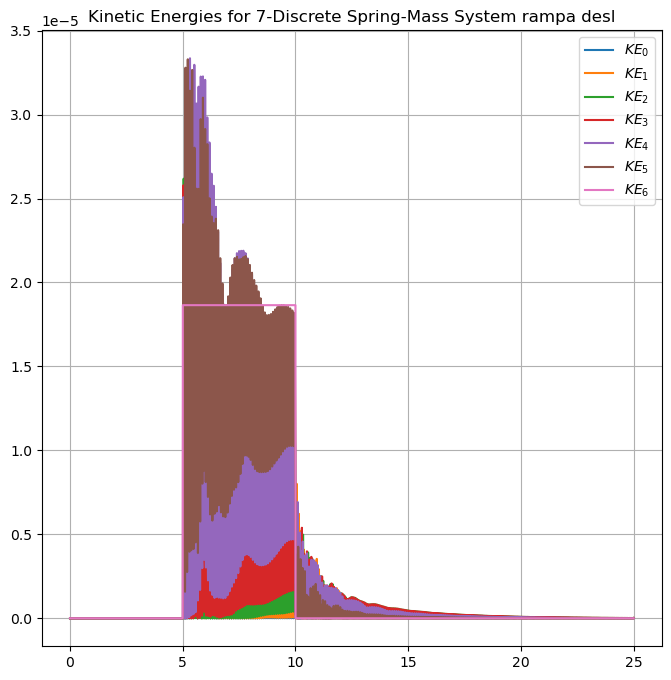

In [ ]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
for i in range(n):
    plt.plot(at,KE[i])
plt.legend([r'$KE_{'+str(i)+'}$' for i in range(n)])
plt.title('Kinetic Energies for '+str(n)+'-Discrete Spring-Mass System rampa desl')

Text(0.5, 1.0, 'Total Energy for 7-Discrete Spring-Mass System rampa desl')

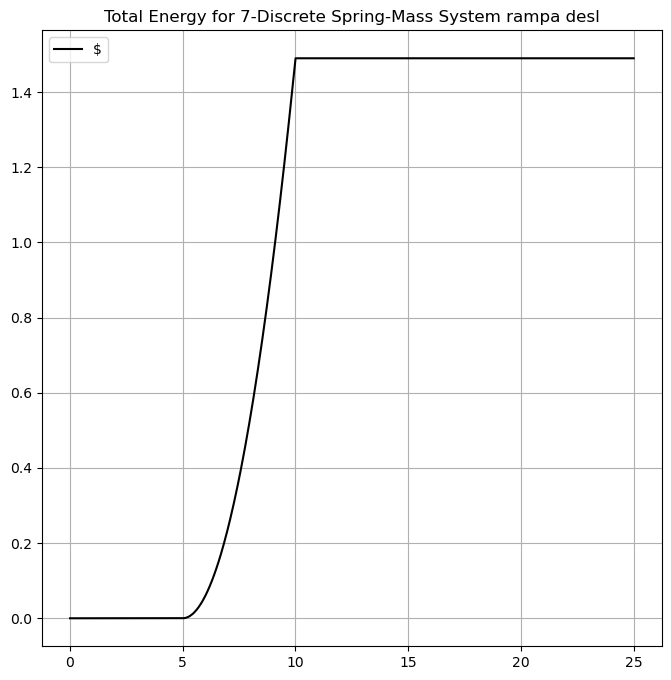

In [ ]:
# adendo
plt.figure(figsize=(8,8))
plt.grid(visible=True)
plt.plot(at,ET,'black')
plt.legend(r'$E_T$')
plt.title('Total Energy for '+str(n)+'-Discrete Spring-Mass System rampa desl')

#### Extremos

In [ ]:
# print(np.array(
#     [ nolds.lyap_e(ax[i]) for i in range(n)]#,emb_dim=28,matrix_dim=10),
# ))
# print([
#   EH.K2En(ax[i], m=4) for i in range(n)
# ])

[[ 4.8519582e-02  6.4022918e-03 -3.6599886e-02 -1.1991183e-01]
 [ 3.6784016e-02  4.3760631e-03 -3.6519166e-02 -1.0573756e-01]
 [ 4.2716473e-02 -9.0922596e-04 -4.3941136e-02 -1.1185101e-01]
 [ 7.5427681e-02  1.3793488e-02 -3.3438455e-02 -1.0181984e-01]
 [ 3.6112029e-02  3.8724334e-03 -3.1838190e-02 -9.9900536e-02]
 [ 9.5059864e-02  1.3175740e-02 -2.9597716e-02 -1.0300269e-01]
 [ 8.6333258e-03 -3.5780091e-02 -8.8676669e-02 -2.0215702e+00]]
[(array([0.0201721 , 0.01241141, 0.00218373, 0.00487779]), array([0.40452009, 0.39644182, 0.39155183, 0.39069772, 0.38879662])), (array([0.0202741 , 0.01235326, 0.00210249, 0.00478201]), array([0.40121258, 0.39316026, 0.38833332, 0.38751772, 0.38566902])), (array([0.02090649, 0.0121221 , 0.00263191, 0.00473228]), array([0.40330239, 0.39495828, 0.39019946, 0.38917383, 0.38733651])), (array([0.02101632, 0.01142024, 0.00287331, 0.00483647]), array([0.40378916, 0.39539155, 0.39090177, 0.3897802 , 0.38789959])), (array([0.02362035, 0.01263629, 0.00517685, 0